# Base Model Using HMM To Predict Market Regime

## Base Functions for model and imports

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm

In [2]:
def calculate_Zscore(df, serie):
    '''
    This function calculates the Z-score of the strategy, which is an indicator of performance on risk
    A Z-score above 2 (average return above 2 standard deviations) is considered 
    '''
    this_df = deepcopy(df)
    return_series = this_df[serie].pct_change()
    return return_series.mean() / (return_series.std(ddof=1) / np.sqrt(return_series.shape))

In [3]:
def compare_strat_perf(train):
    '''
    This function compares the trading performance of the Long-Only strategy to the HMM based strategy
    '''
    baseline_perf   = train['Close'].iloc[-1] / train['Close'].iloc[0] - 1
    hmm_perf        = train['trading_sim'].iloc[-1] / train['trading_sim'].iloc[0] - 1
    nb_years        = (datetime.strptime(train['Date'].iloc[-1], '%Y-%m-%d') - datetime.strptime(train['Date'].iloc[0], '%Y-%m-%d')).days / 365
    baseline_y_perf = (1 + baseline_perf) ** (1 / nb_years) - 1
    hmm_y_perf      = (1 + hmm_perf) ** (1 / nb_years) - 1
    
    print('For the buy and hold trading strategy => Overall return = %0.2f%%  ~  Yearly return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * baseline_perf, 100 * baseline_y_perf, calculate_Zscore(train, 'Close')))
    print('For the HMM based    trading strategy => Overall return = %0.2f%%  ~  Yearly return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * hmm_perf, 100 * hmm_y_perf, calculate_Zscore(train, 'trading_sim')))

In [4]:
def graph_prediction(predictions, train, loser, this_set='Train'):
    '''
    This function plots a comparative graph of the Long-Only strategy and the HMM based strategy.
    It will shade the periods of the losing state, for which the HMM strategy will remain out of the market.
    '''
    predictions_start = np.where((predictions == loser) & (np.diff(np.pad(predictions, (1, 0), 'constant', constant_values=-99)) != 0))[0]
    predictions_end   = np.where((predictions == loser) & (np.diff(np.pad(predictions, (0, 1), 'constant', constant_values=-99)) != 0))[0]


    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    train.plot(x='Date', y='Close', color='dodgerblue', label='Long Only', ax=ax)
    train.plot(x='Date', y='trading_sim', color='orange', label='With HMM Regime detection', ax=ax)
    for st, end in zip(predictions_start, predictions_end):
        ax.axvspan(st, end, alpha=0.2, color='cyan')
    plt.title(f'{this_set} set Trading Simulation', fontsize=26)
    plt.grid()
    plt.legend()
    plt.show()
    compare_strat_perf(train)

## Loading The Data And Setting Up

**first we set the global variables.**

we will set the hidden state to 3 for the 3 state we want to predict by:
* winner state - low volatility and positive return rate
* winner state - High volatility and positive return rate
* losser state - High volatility and negetive return rate

In [5]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 100;

**then we read the data and delete the unwanted data**

we will load the "SPY" ETF data into a data frame and rename the colmes and remove what we dont want to keep.

In [6]:
df = pd.read_csv('data/SPY.csv')

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

**Here is our remaining DF**

Let us now plot the whole DF and see the graph.

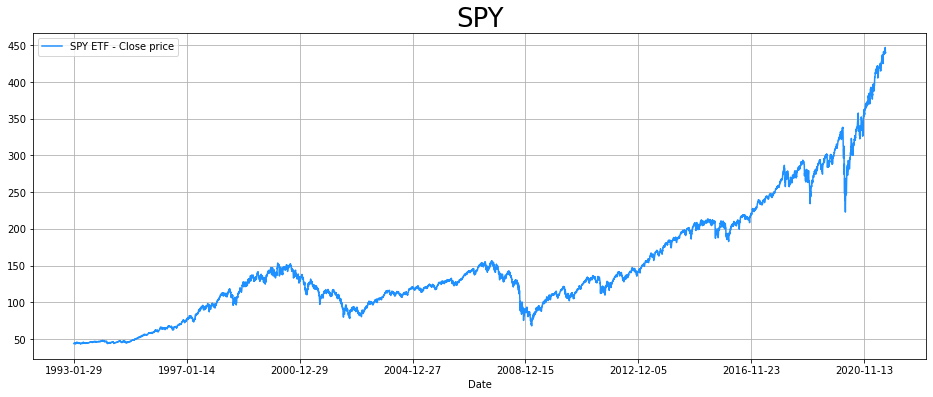

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df.plot(x='Date', y='Close', color='dodgerblue', label='SPY ETF - Close price', ax=ax)
plt.title('SPY', fontsize=26)
plt.grid()
plt.legend();

In [8]:
df

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7187,2021-08-13,445.920013
7188,2021-08-16,446.970001
7189,2021-08-17,444.040009
7190,2021-08-18,439.179993


We can see a positive trend thru time - that is if we left our monney and leave it there for 20 years we would have gained a profit.

But we new how to avoid the market down falls we would win more ! 

## Basic Data Manipulations

**Now we will calculte the Moving Avg and Volatility**

Now let's set the MA and then Volatility for some number of days - 10,30,60,120 and add the daily Return of the SPY in percentage

In [9]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
for period in hist_periods:
    df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
    df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
df['Return'] = df['Close'].pct_change() * 100
df.fillna(0,inplace=True)
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1993-01-29,43.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1993-02-01,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.711238
2,1993-02-02,44.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211864
3,1993-02-03,44.812500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.057082
4,1993-02-04,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418410
...,...,...,...,...,...,...,...,...,...,...,...
7187,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984
7188,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466
7189,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523
7190,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500


This is our final DF with all moving average and the Return values

## Train Test Spliting

**now we mark the test train randomly for 10 years**

In [10]:
# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0] - 2*year

# and end index for the ending
end_test_idx = df.shape[0]

**divide the data**

In [11]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx + 1, end_test_idx)).reset_index(drop=True)

In [12]:
train.shape, test.shape

((4047, 11), (503, 11))

## Creating The Model

**we will now create a model for HMM**

In [13]:
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26);

**we will set the Data to be Fitted on the Historical 10 days Volatility and the return.**

In [14]:
columns_to_keep = ['Return', 'hist_vol_10_days']
obs = train[columns_to_keep].to_numpy()

**Fitting the model and obtaining predictions**

In [15]:
model.fit(obs)
predictions = model.predict(obs)

**now we plot the predictions on simple graphs**

we can see that we have 3 points to plot as we noted above.

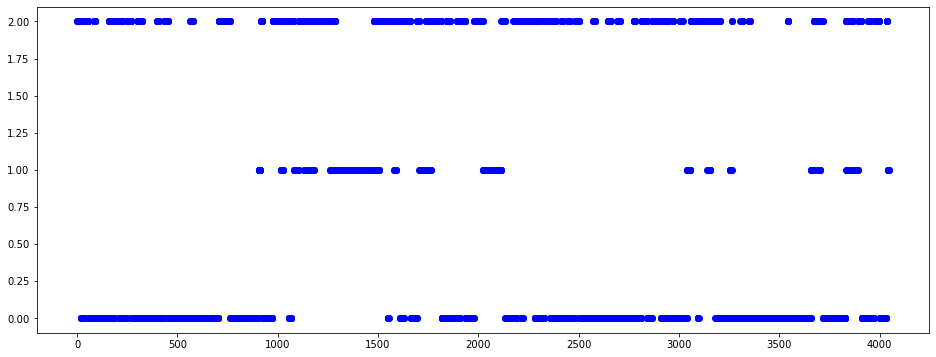

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(predictions, 'bo');

**lets plot the state with regards to the closing**

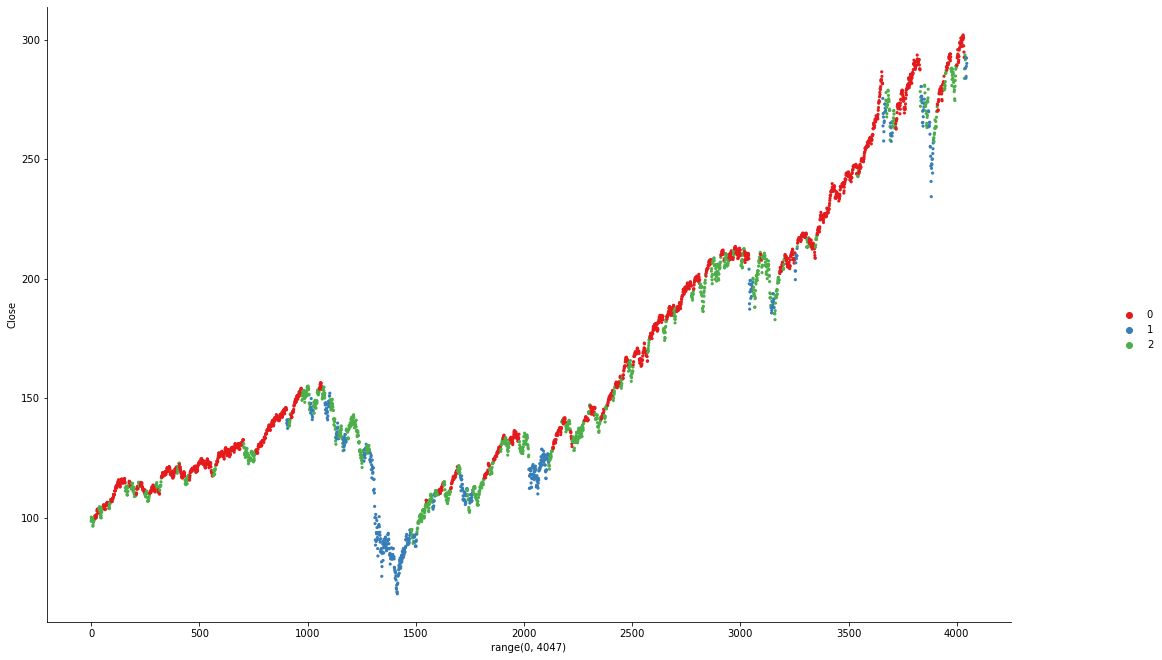

In [17]:
plot = sns.relplot(x=range(0,train.shape[0]), y="Close", data=train, hue=predictions, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)

In [18]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 2685.7842698769796


In [19]:
res_train = deepcopy(train)
res_train['prediction'] = predictions
res_total = res_train[[x for x in columns_to_keep] + ['prediction']].groupby('prediction').mean().reset_index()
res_total

,prediction,Return,hist_vol_10_days
0,0,0.063921,0.082839
1,1,-0.040606,0.346257
2,2,0.016069,0.159298


In [20]:
loser_state = res_total['Return'].argmin()
winner_state = res_total['Return'].argmax()
loser_state, winner_state

(1, 0)

**we can see 1 is the "loser state" (it changes for each iteration...) we will choose the other states**

## Train Prediction

we will now predict outcomes and use our model to prdict out the market regime.

In [21]:
first_trading = train['Close'].iloc[0]
trading = [first_trading]
for day, (daily_return, prediction) in enumerate(zip(train['Return'][1:], predictions[1:]), start=1):
    trading.append(trading[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
train['trading_sim'] = trading
train

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,100.230003
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,99.860001
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,99.400002
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,99.160004
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,426.407450
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,426.407450
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,426.407450
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,426.407450


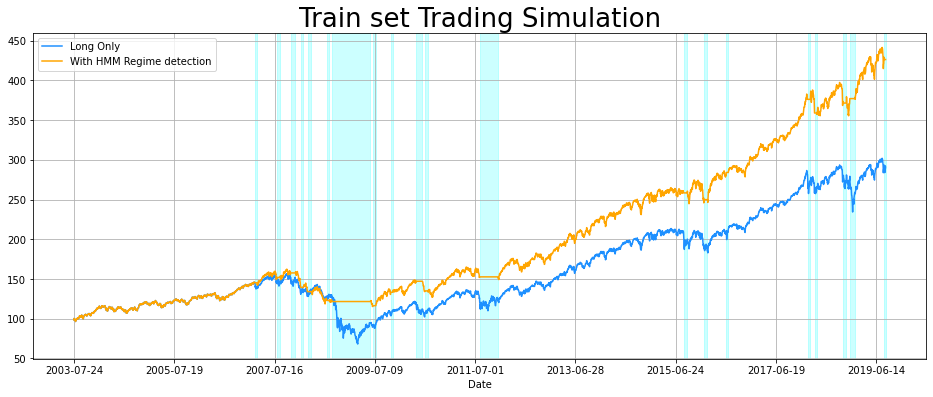

For the buy and hold trading strategy => Overall return = 194.54%  ~  Yearly return = 6.95%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 332.94%  ~  Yearly return = 9.54%  ~  Z-score = 3.481


In [22]:
graph_prediction(predictions, train, loser_state, 'Train')

We see that our model managed to detect some periods of bear market, and overall it has a significantly better return than the Long-Only model!<br>
It has also a Z-score almost twice as good, which means it seems valuable!

# Now let's test the model on the test data !

In [23]:
obs_test = test[columns_to_keep].to_numpy()

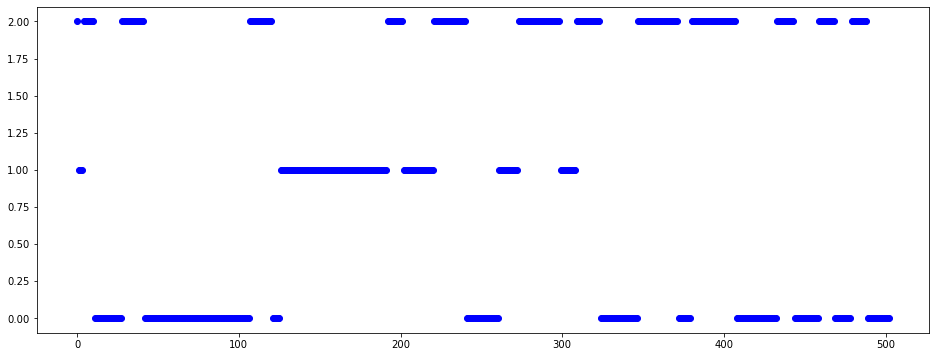

In [24]:
predictions_test = model.predict(obs_test)
plt.figure(figsize=(16, 6))
plt.plot(predictions_test, 'bo');

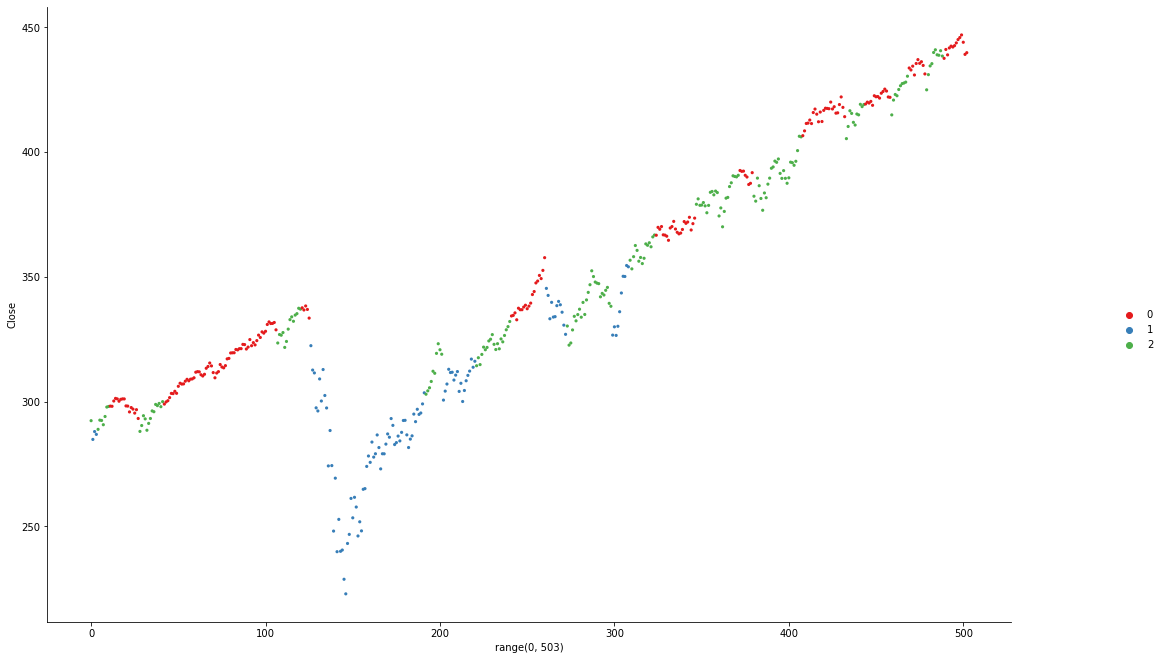

In [25]:
plot = sns.relplot(x=range(0,test.shape[0]), y="Close", data=test, hue=predictions_test, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)

In [26]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 2685.7842698769796


In [27]:
first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_test[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
test['trading_sim'] = trading_test
test

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2019-08-22,292.359985,-0.006827,0.225971,-0.012432,0.182743,0.013068,0.150932,0.005998,0.134816,-0.030784,292.359985
1,2019-08-23,284.850006,-0.037287,0.259275,-0.028566,0.196015,0.005462,0.160575,0.002736,0.140122,-2.568744,292.359985
2,2019-08-26,288.000000,-0.000386,0.260680,-0.022922,0.199431,0.011961,0.159373,0.004994,0.140693,1.105843,292.359985
3,2019-08-27,286.869995,-0.031124,0.246257,-0.023293,0.199495,0.011594,0.159521,0.005585,0.140255,-0.392363,292.359985
4,2019-08-28,288.890015,0.027660,0.192419,-0.015967,0.200297,0.007769,0.154152,0.006778,0.140543,0.704159,294.418663
...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984,526.468320
499,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466,527.707971
500,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523,524.248723
501,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500,518.510823


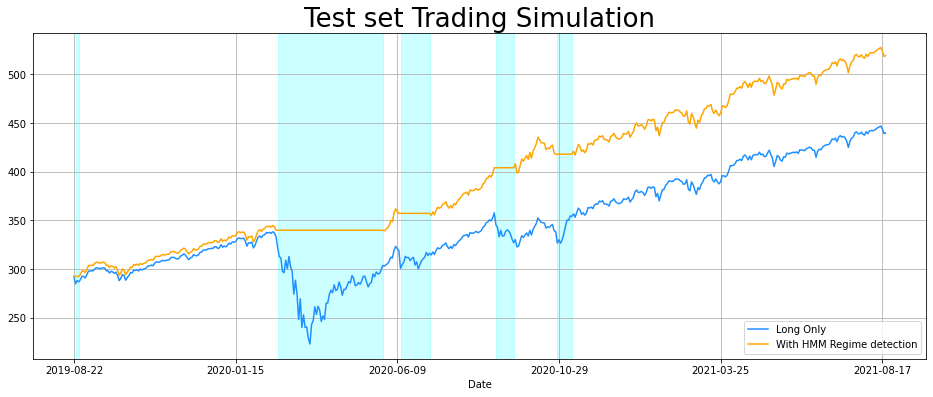

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 77.63%  ~  Yearly return = 33.38%  ~  Z-score = 3.838


In [28]:
graph_prediction(predictions_test, test, loser_state, 'Test')

Wow... This result just seems to be too good to be true... Are we on the path to the Fortune?... Or did we make a mistake with our data?....

Let's have a closer look at our data...<br>
According to the documentation of hmmlearn, the 'predict' function findd most likely state sequence corresponding to the observed states... In other words, when we gave the model the observed outputs, we got the estimated states at each step... But we cannot do Back-trading based on the whole picture!! We need to do a 'predict' step by step based only on the path *before* the prediction time... Let's do it now...

In [29]:
predictions_list = []
predictions_list_all = []
for i, index in enumerate(obs_test):
    this_predict = model.predict(np.vstack((obs, obs_test[:i])))
    predictions_list.append(this_predict[-1])
    predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(obs_test) - i))

In [30]:
len(predictions_list_all)

503

In [31]:
test['trading_sim_leaked_data'] = test['trading_sim']

first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_list[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
test['trading_sim'] = trading_test
test

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim,trading_sim_leaked_data
0,2019-08-22,292.359985,-0.006827,0.225971,-0.012432,0.182743,0.013068,0.150932,0.005998,0.134816,-0.030784,292.359985,292.359985
1,2019-08-23,284.850006,-0.037287,0.259275,-0.028566,0.196015,0.005462,0.160575,0.002736,0.140122,-2.568744,292.359985,292.359985
2,2019-08-26,288.000000,-0.000386,0.260680,-0.022922,0.199431,0.011961,0.159373,0.004994,0.140693,1.105843,292.359985,292.359985
3,2019-08-27,286.869995,-0.031124,0.246257,-0.023293,0.199495,0.011594,0.159521,0.005585,0.140255,-0.392363,292.359985,292.359985
4,2019-08-28,288.890015,0.027660,0.192419,-0.015967,0.200297,0.007769,0.154152,0.006778,0.140543,0.704159,292.359985,294.418663
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984,436.205993,526.468320
499,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466,437.233108,527.707971
500,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523,434.366944,524.248723
501,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500,429.612799,518.510823


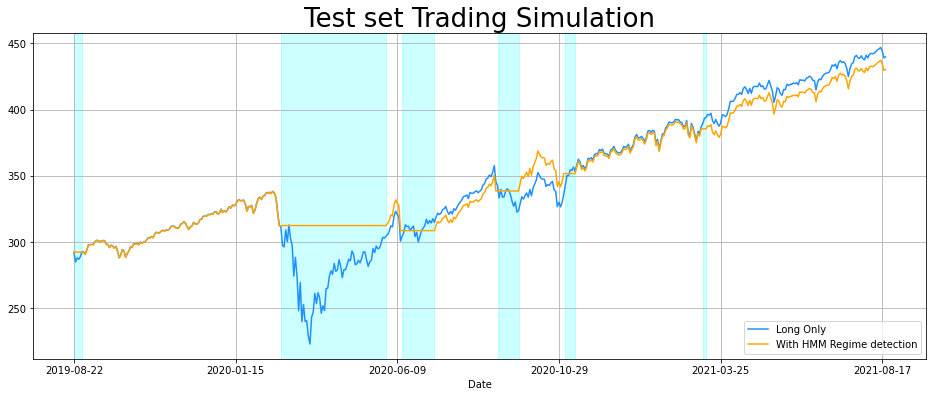

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 47.17%  ~  Yearly return = 21.38%  ~  Z-score = 2.296


In [32]:
graph_prediction(predictions_list, test, loser_state, 'Test')

Back on earth... Our HMM could not achieve (at this stage...) a better overall return than the Long-Only strategy...<br>
BUT it did achieve a better Z-score than the Long-Only, meaning the volatility of the HMM based strategy was significantly lower than the volatility of the Buy and Hold strategy, which is highly valuable!

## Checking the Data with line plot and color to spot the changes

We would like to check now if there were many events of prediction change backwards.

In [33]:
nb_lines, sanity_check, nb_cols = len(predictions_list_all[0]), len(predictions_list_all[-1]), len(predictions_list_all)
nb_lines, sanity_check, nb_cols

(4550, 4550, 503)

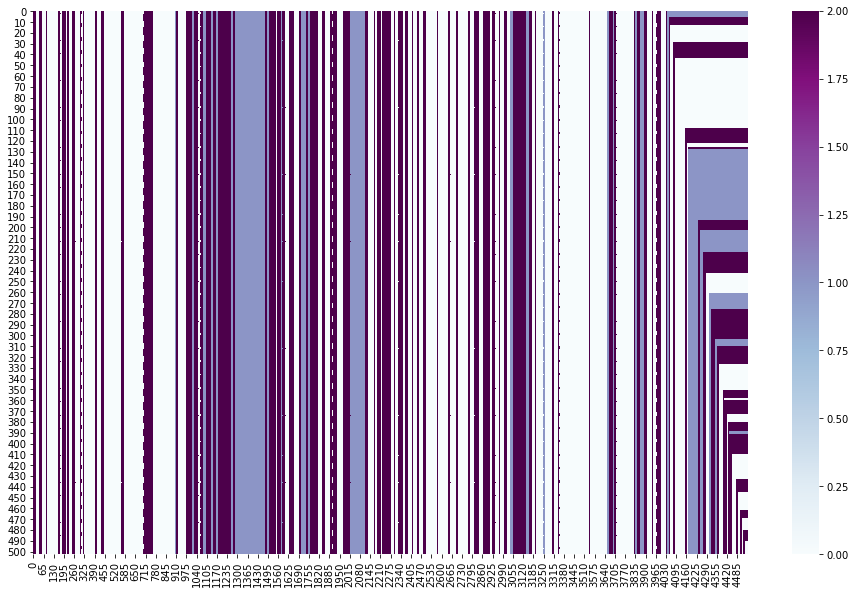

In [34]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all), cmap="BuPu");

We would like to check if there was any change in the "predict" of the model on the train set. Let's have a look!

In [35]:
pred_df = pd.DataFrame(np.array(predictions_list_all).T)
set(pred_df.iloc[:4047, :].sum(axis='columns') % 503)

{0}

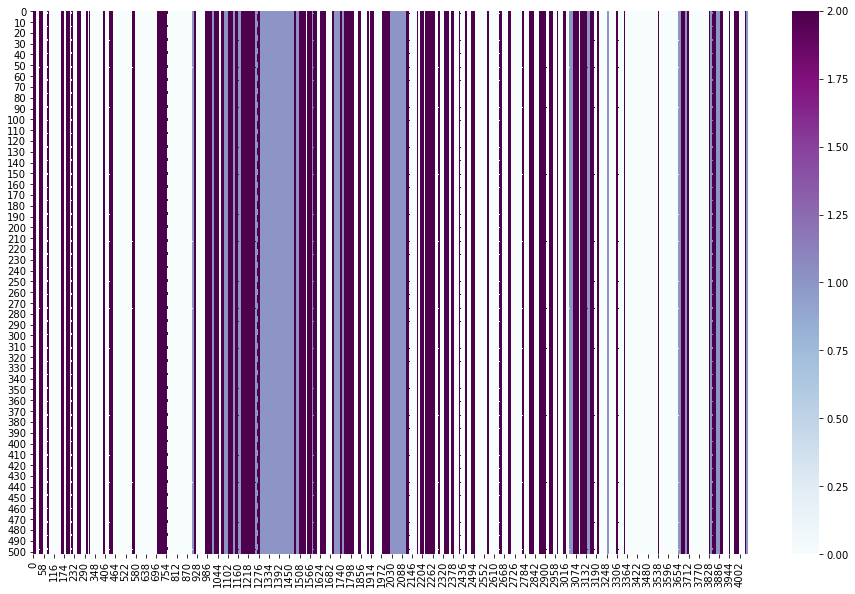

In [36]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, :4047], cmap="BuPu");

We can see that there was no change at all. The way we checked it is as follows: For each point in the observation_test we run a "predict" on the whole series of data, including the initial train set (obs) and an increasing number of points from the test set. Then we stack all these predictions, just keeping the last point and copying it to the end (to have the same number of points for all the predictions). Eventually, I draw a heatmap of all the predictions, to see if all the points predicted for the train and test sets are predicted the same.<br>
Moreover, on the train set we sum all the columns numbers and compute modulo 503 (the number of test points) to check if there were some different predictions in the train set for different numbers of added test points. And we got 0 ! Meaning for all the steps of the test set prediction, we had 503 times the exact same Hidden State prediction for each point of the train set!

Let's have a closer look at the test set now.

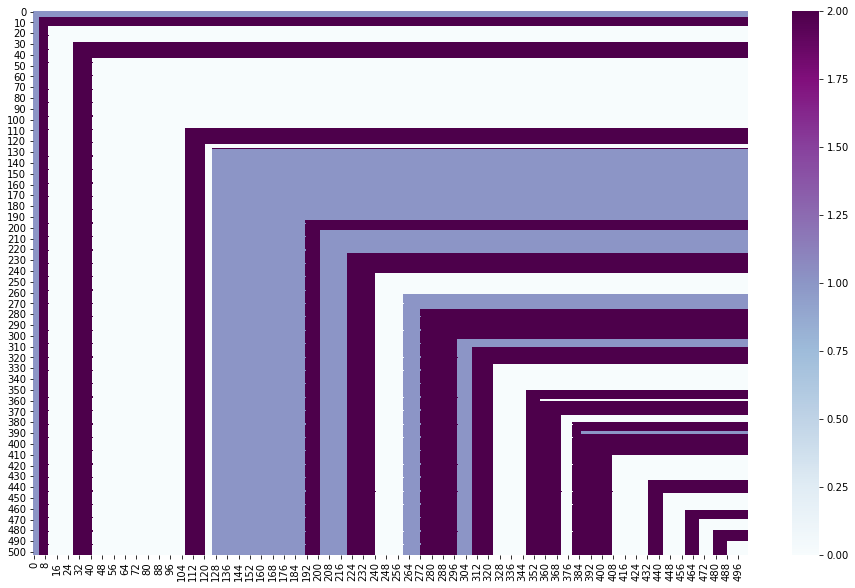

In [37]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, 4047:], cmap="BuPu");

This looks like psychedelic... But we can see here that there are at least 3 times for which the prediction for the point t will eventually be overriden later when further points will be available... <br>
Let's have a look at the numbers.

In [38]:
test_predict = np.array(predictions_list_all)[:, -503:]
test_predict.shape

(503, 503)

In [39]:
for i in range(test_predict.shape[0] - 1):
    if len(set(test_predict[i+1:, i].tolist())) > 1:
        print(f'There is a prediction override for the test point {i} !!')

There is a prediction override for the test point 4 !!
There is a prediction override for the test point 11 !!
There is a prediction override for the test point 12 !!
There is a prediction override for the test point 42 !!
There is a prediction override for the test point 107 !!
There is a prediction override for the test point 121 !!
There is a prediction override for the test point 126 !!
There is a prediction override for the test point 192 !!
There is a prediction override for the test point 221 !!
There is a prediction override for the test point 222 !!
There is a prediction override for the test point 241 !!
There is a prediction override for the test point 273 !!
There is a prediction override for the test point 274 !!
There is a prediction override for the test point 299 !!
There is a prediction override for the test point 300 !!
There is a prediction override for the test point 301 !!
There is a prediction override for the test point 302 !!
There is a prediction override for t

## Selecting diffrent methodes to predict. 

**Now let's package the whole model and run it on several other columns**

In [40]:
def run_hmm_model(df_train, df_test, keep_columns):
    """
    This function will do the whole job for a given subset of columns:
    1- Initiate the HMM model and fit it to the TRAIN dataframe
    2- Plot a graph of the regimes and the Asset with regime color
    3- Calculate the Model Score
    4- Display the winner / loser / average states
    5- Display states, simulate Trading and Graph Predictions of the HMM model on TRAIN SET
    6- Define TEST SET and generate step-by-step predictions
    7- Display states, simulate Trading and Graph Predictions of the HMM model on TEST SET
    """
    
    # define the reduced DataFrame and train the model
    this_train = deepcopy(df_train)
    this_obs = this_train[keep_columns].to_numpy()
    this_model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26)
    this_model.fit(this_obs)
    this_predictions = this_model.predict(this_obs)
    print('\n')
    
    # Plot the regimes path and the colorful Index points
    plt.figure(figsize=(16, 6))
    plt.plot(this_predictions, 'bo')
    plt.title('Path to Regimes')
    plt.show()
    plot = sns.relplot(x=range(0,df_train.shape[0]), y="Close", data=df_train, hue=this_predictions, linewidth = 0, palette="Set1", s = 10);
    plot.fig.set_size_inches(18,10)
    plot.fig.suptitle('SPY ETF with relevant regime')
    plt.show()
    print('\n')
    
    # Print model score
    print("Model Score: {0}".format(this_model.score(this_obs)));
    
    # Display states
    this_res_train = deepcopy(df_train)
    this_res_train['prediction'] = this_predictions
    this_res_total = this_res_train[[x for x in keep_columns] + ['prediction']].groupby('prediction').mean().reset_index()
    display(this_res_total)
    
    this_loser_state = this_res_total['Return'].argmin()
    this_winner_state = this_res_total['Return'].argmax()
    this_loser_state, this_winner_state
    print(f'The Winner State is: {this_winner_state} / The Loser State is: {this_loser_state}')
    
    # Display states and simulate Trading
    this_first_trading = df_train['Close'].iloc[0]
    this_trading = [this_first_trading]
    for day, (daily_return, prediction) in enumerate(zip(df_train['Return'][1:], this_predictions[1:]), start=1):
        this_trading.append(this_trading[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state))))
    this_train['trading_sim'] = this_trading
    display(this_train)
    
    # Graph Predictions on TRAIN SET
    graph_prediction(this_predictions, this_train, this_loser_state, 'Train')
    
    # Define TEST SET and generate predictions
    this_test = deepcopy(df_test)
    this_obs_test = this_test[keep_columns].to_numpy()
    this_predictions_list = []
    this_predictions_list_all = []
    for i, index in enumerate(this_obs_test):
        this_predict = this_model.predict(np.vstack((this_obs, this_obs_test[:i])))
        this_predictions_list.append(this_predict[-1])
        this_predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(this_obs_test) - i))
        
    # Display states and simulate Trading
    this_first_trading_test = df_test['Close'].iloc[0]
    this_trading_test = [this_first_trading_test]
    this_predictions_test = np.array(this_predictions_list)
    for day, (daily_return, prediction) in enumerate(zip(df_test['Return'][1:], this_predictions_test[1:]), start=1):
        this_trading_test.append(this_trading_test[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state) * (1 + 0 * (prediction == this_winner_state)))))
    this_test['trading_sim'] = this_trading_test

    graph_prediction(this_predictions_list, this_test, this_loser_state, 'Test')

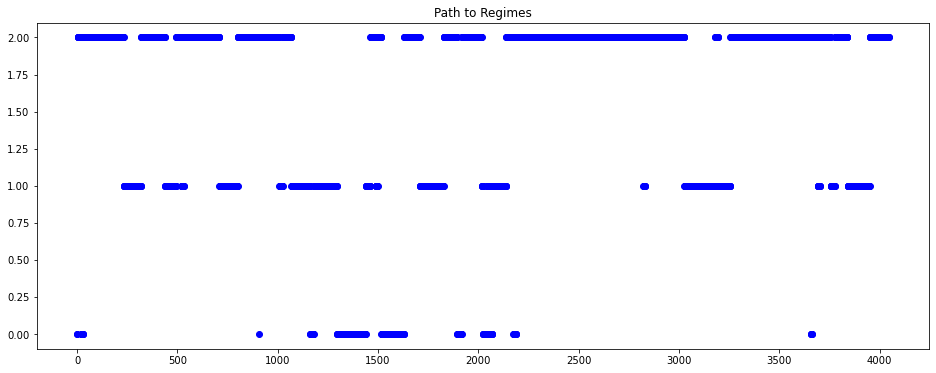

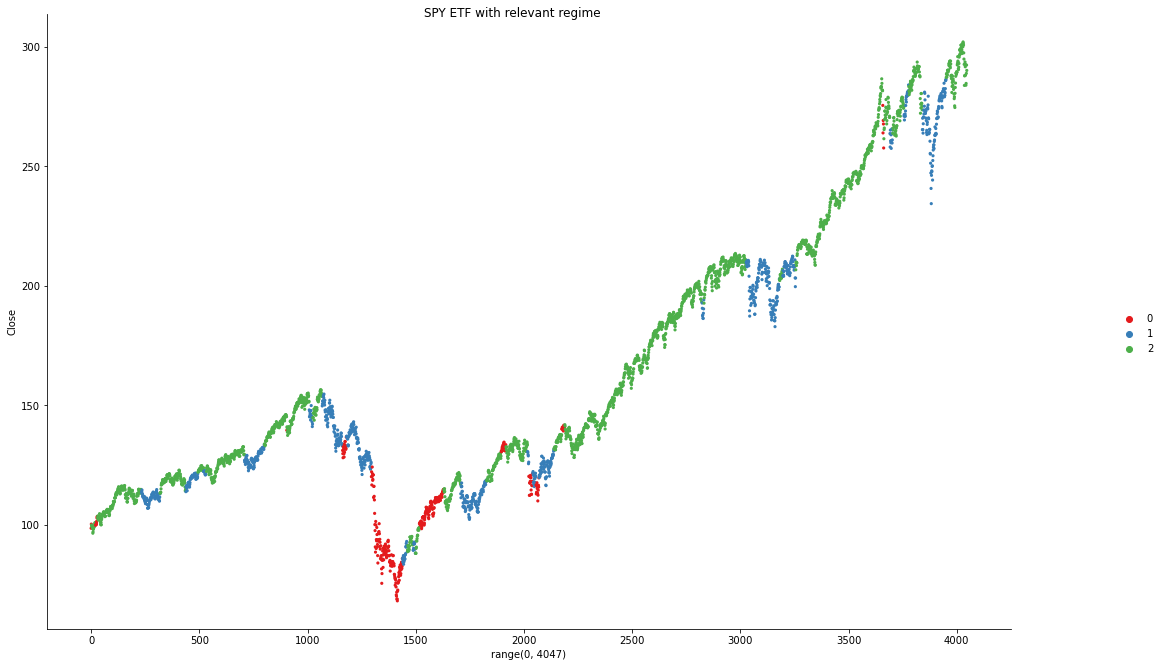



Model Score: 9268.490713800516


,prediction,Return,MA_120_days
0,0,-0.050933,-0.009469
1,1,-0.009048,-0.004106
2,2,0.062037,0.010034


The Winner State is: 2 / The Loser State is: 0


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,98.489998
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,98.126419
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,97.674406
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,97.438574
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,380.811999
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,381.818019
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,387.451745
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,392.119652


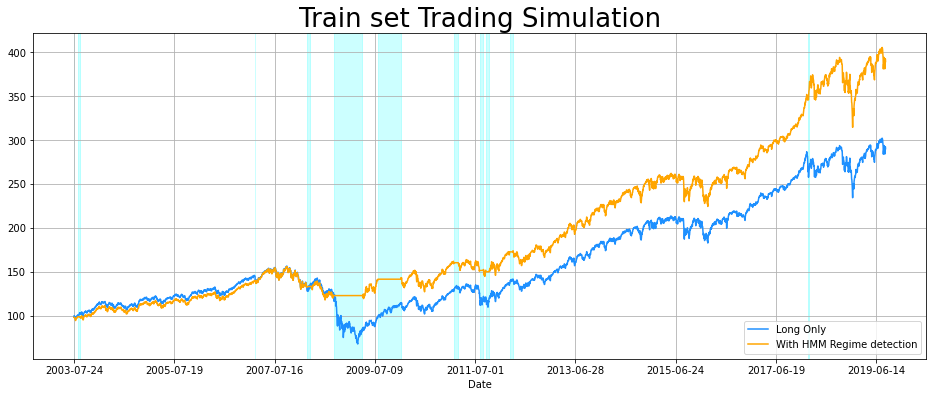

For the buy and hold trading strategy => Overall return = 194.54%  ~  Yearly return = 6.95%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 295.08%  ~  Yearly return = 8.92%  ~  Z-score = 2.848


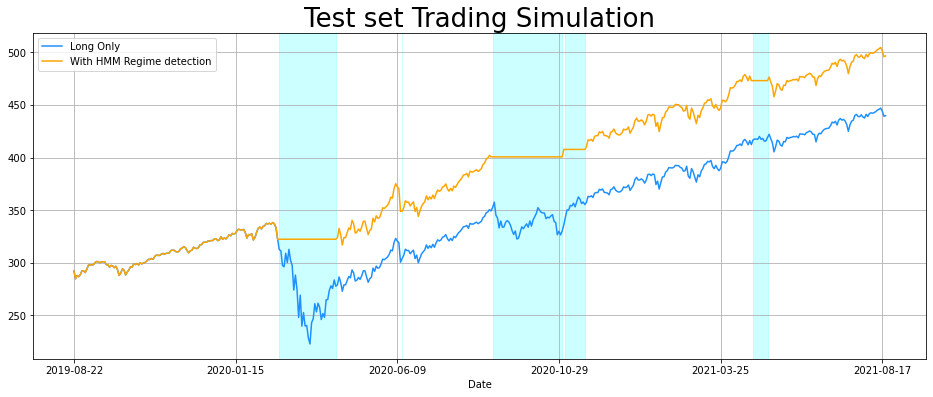

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 69.85%  ~  Yearly return = 30.42%  ~  Z-score = 2.941


In [41]:
columns_to_remove = ['Date', 'Close']
columns_to_keep = [x for x in train.columns if x not in columns_to_remove]
columns_to_keep = ['Return', 'MA_120_days']
run_hmm_model(train, test, columns_to_keep)

Wow again!! This seems to be for real now !
In this function we perform the whole process on some selected columns, and assess the results on the test set. When we run our HMM model on the 'Return' and 'MA_120_days' (the moving average of the return on 120 days) and we got outstanding results!

## Other ETF Tests

now lets check this on other ETF's So we can see the outcome of our model and method.

In [42]:
df = pd.read_csv('data/IXIC.csv')

In [43]:
df.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]

In [44]:

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

* Here is our remaining DF

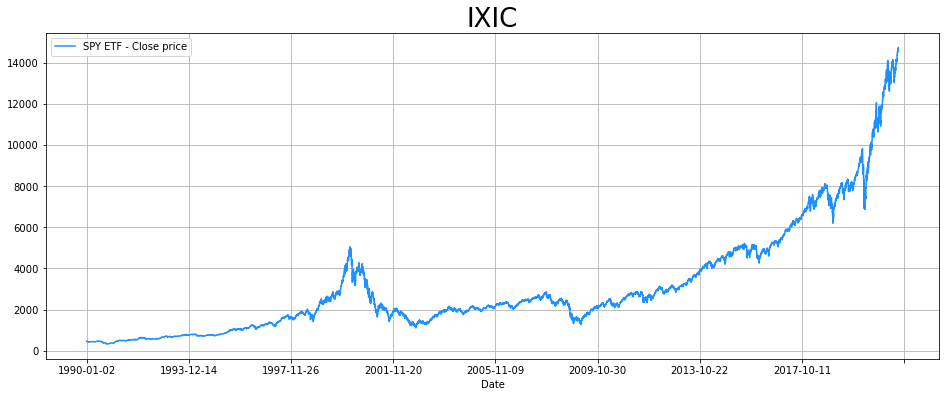

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df.plot(x='Date', y='Close', color='dodgerblue', label='SPY ETF - Close price', ax=ax)
plt.title('IXIC', fontsize=26)
plt.grid()
plt.legend();

In [46]:
df

,Date,Close
0,1990-01-02,459.30
1,1990-01-03,460.90
2,1990-01-04,459.40
3,1990-01-05,458.20
4,1990-01-08,458.70
...,...,...
7938,2021-07-06,14663.64
7939,2021-07-07,14665.06
7940,2021-07-08,14559.78
7941,2021-07-09,14701.92


* Now let's set the MA and then Volatility for some number of days, and add the daily Return of the SPY in percentage

In [47]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
for period in hist_periods:
    df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
    df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
df['Return'] = df['Close'].pct_change() * 100
df.fillna(0,inplace=True)
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1990-01-02,459.30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1990-01-03,460.90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348356
2,1990-01-04,459.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.325450
3,1990-01-05,458.20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.261210
4,1990-01-08,458.70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109123
...,...,...,...,...,...,...,...,...,...,...,...
7938,2021-07-06,14663.64,0.057559,0.064573,0.044889,0.094947,0.014146,0.149829,0.015195,0.198323,0.166060
7939,2021-07-07,14665.06,0.045213,0.061998,0.037522,0.089081,0.015129,0.149544,0.014637,0.198266,0.009684
7940,2021-07-08,14559.78,0.031721,0.080023,0.033865,0.093037,0.010447,0.149120,0.013849,0.198592,-0.717897
7941,2021-07-09,14701.92,0.036282,0.085971,0.035883,0.095014,0.015644,0.148597,0.016290,0.198501,0.976251


* This is our final DF with all moving average and the Return values

In [48]:
# now we mark the test train randomly

# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0] - 2*year

# and end index for the ending
end_test_idx = df.shape[0]

In [49]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx + 1, end_test_idx)).reset_index(drop=True)

* see the shapes

In [50]:
train.shape, test.shape

((4798, 11), (503, 11))

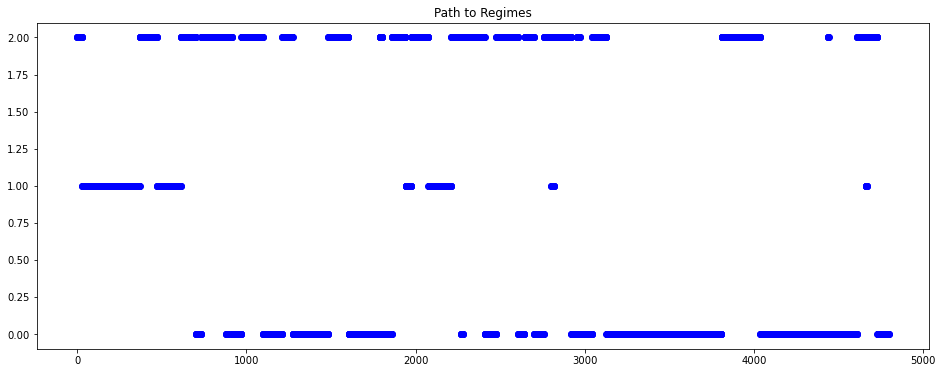

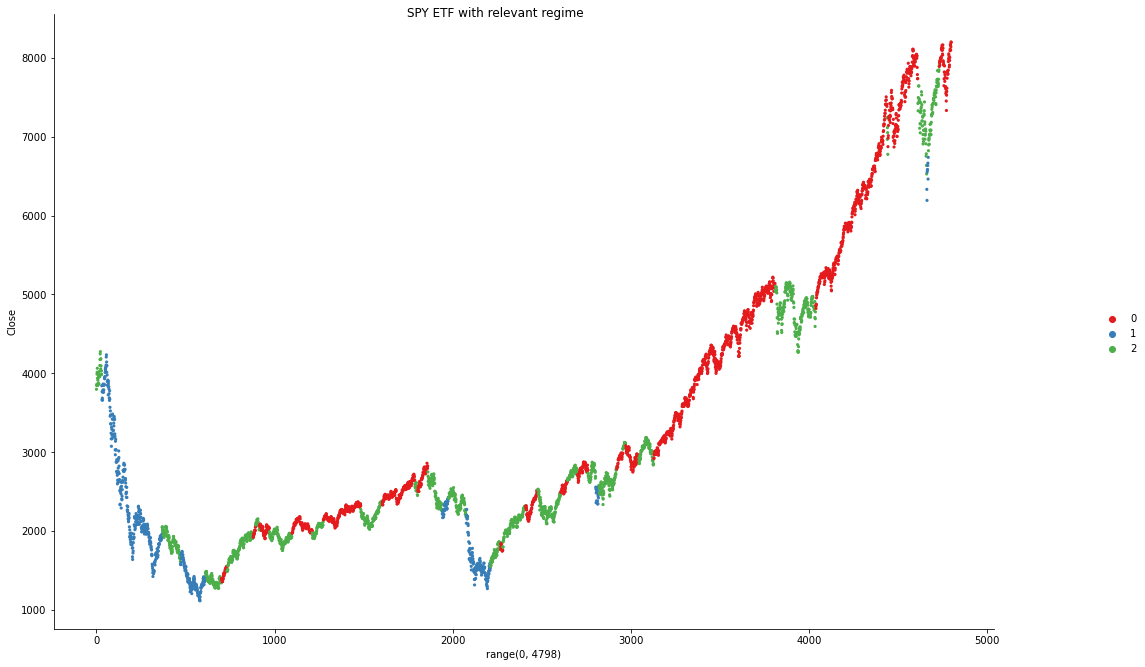



Model Score: 7499.964125171936


,prediction,Return,MA_120_days
0,0,0.085586,0.012614
1,1,-0.116273,-0.038650
2,2,0.008236,0.004196


The Winner State is: 0 / The Loser State is: 1


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2000-06-14,3797.41,0.175058,0.467406,0.001669,0.532306,-0.051303,0.616682,-0.004786,0.509584,-1.393123,3797.410000
1,2000-06-15,3845.74,0.112558,0.408847,0.019398,0.529691,-0.053730,0.615376,-0.004188,0.509784,1.272710,3845.740000
2,2000-06-16,3860.56,0.019520,0.268340,0.019591,0.529706,-0.061171,0.611159,-0.003877,0.509813,0.385361,3860.560000
3,2000-06-19,3989.83,0.068320,0.312223,0.023458,0.533043,-0.056550,0.614557,0.000589,0.512074,3.348478,3989.830000
4,2000-06-20,4013.36,0.105051,0.288160,0.047415,0.518838,-0.056192,0.614639,-0.000923,0.511525,0.589749,4013.360000
...,...,...,...,...,...,...,...,...,...,...,...,...
4793,2019-07-05,8161.79,0.021629,0.117122,0.027337,0.155189,0.008315,0.159183,0.020853,0.149429,-0.103302,24053.865548
4794,2019-07-08,8098.38,0.013123,0.124830,0.031644,0.148802,0.004419,0.159514,0.021071,0.149196,-0.776913,23866.987962
4795,2019-07-09,8141.73,0.026747,0.124428,0.033864,0.149090,0.006393,0.159767,0.019538,0.147566,0.535292,23994.746097
4796,2019-07-10,8202.53,0.062730,0.083443,0.039860,0.148728,0.007139,0.160189,0.020318,0.147839,0.746770,24173.931671


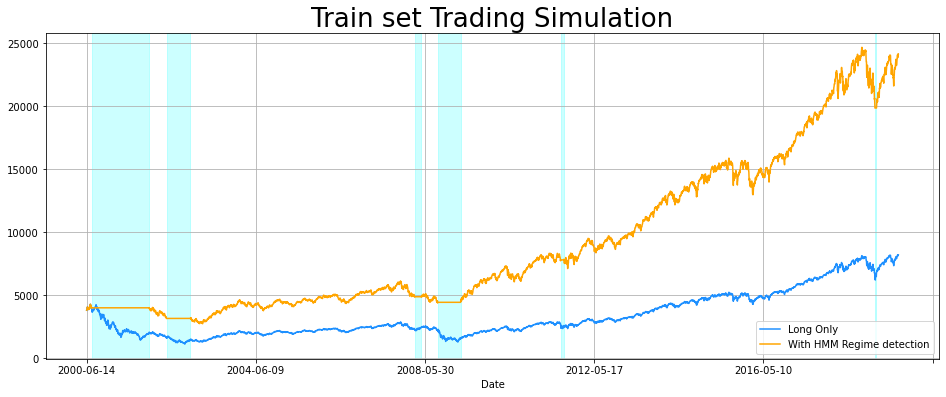

For the buy and hold trading strategy => Overall return = 115.83%  ~  Yearly return = 4.11%  ~  Z-score = 1.257
For the HMM based    trading strategy => Overall return = 536.09%  ~  Yearly return = 10.18%  ~  Z-score = 2.955


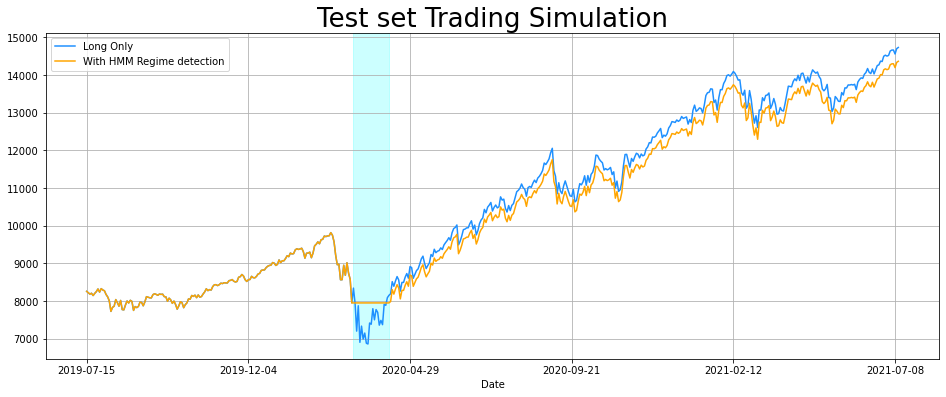

For the buy and hold trading strategy => Overall return = 78.41%  ~  Yearly return = 33.68%  ~  Z-score = 1.663
For the HMM based    trading strategy => Overall return = 73.97%  ~  Yearly return = 32.00%  ~  Z-score = 1.996


In [51]:
columns_to_remove = ['Date', 'Close']
columns_to_keep = [x for x in train.columns if x not in columns_to_remove]
columns_to_keep = ['Return', 'MA_120_days']
run_hmm_model(train, test, columns_to_keep)

As we can see its preforming very well ! - almost at the market we maybe lost 5 percent ... but if we can change and tweak we would win big time.

### Now lets check a diffrent One

In [52]:
df = pd.read_csv('data/DJI.csv')

In [53]:
df.head(3)

,formatted_date,high,low,open,close,volume,adjclose
0,1992-01-02,3172.63,3139.31,3152.1,3172.4,23550000,3172.4
1,1992-01-03,3210.64,3165.92,3172.4,3201.5,23620000,3201.5
2,1992-01-06,3213.33,3191.86,3201.5,3200.1,27280000,3200.1


In [54]:
df.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]

In [55]:

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

* Here is our remaining DF

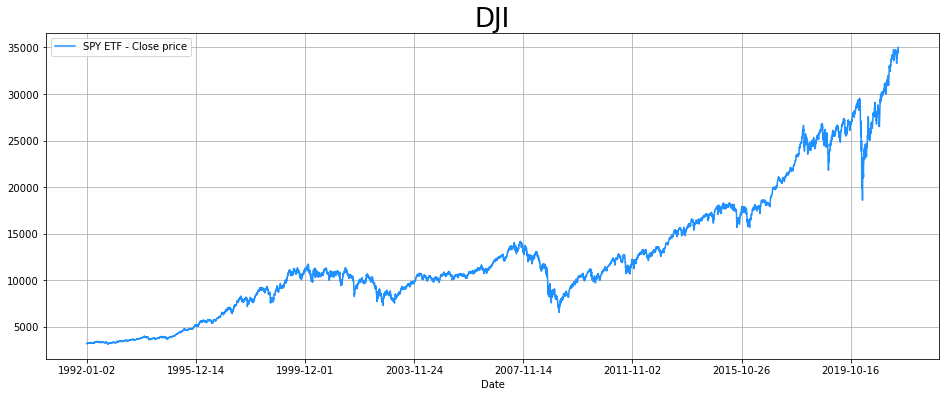

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df.plot(x='Date', y='Close', color='dodgerblue', label='SPY ETF - Close price', ax=ax)
plt.title('DJI', fontsize=26)
plt.grid()
plt.legend();

In [57]:
df

,Date,Close
0,1992-01-02,3172.40
1,1992-01-03,3201.50
2,1992-01-06,3200.10
3,1992-01-07,3204.80
4,1992-01-08,3203.90
...,...,...
7432,2021-07-06,34577.37
7433,2021-07-07,34681.79
7434,2021-07-08,34421.93
7435,2021-07-09,34870.16


* Now let's set the MA and then Volatility for some number of days, and add the daily Return of the SPY in percentage

In [58]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
for period in hist_periods:
    df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
    df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
df['Return'] = df['Close'].pct_change() * 100
df.fillna(0,inplace=True)
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1992-01-02,3172.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1992-01-03,3201.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917287
2,1992-01-06,3200.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.043730
3,1992-01-07,3204.80,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146870
4,1992-01-08,3203.90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.028083
...,...,...,...,...,...,...,...,...,...,...,...
7432,2021-07-06,34577.37,0.032486,0.080400,0.005685,0.095917,0.006011,0.108414,0.014155,0.122058,-0.600753
7433,2021-07-07,34681.79,0.034061,0.080546,0.004410,0.095061,0.007242,0.108464,0.014589,0.122085,0.301989
7434,2021-07-08,34421.93,0.025461,0.092284,0.001686,0.097449,0.005786,0.109581,0.013888,0.122614,-0.749269
7435,2021-07-09,34870.16,0.030953,0.101703,0.008368,0.104309,0.008789,0.112550,0.016358,0.123465,1.302164


* This is our final DF with all moving average and the Return values

In [59]:
# now we mark the test train randomly

# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0] - 2*year

# and end index for the ending
end_test_idx = df.shape[0]

In [60]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx + 1, end_test_idx)).reset_index(drop=True)

* see the shapes

In [61]:
train.shape, test.shape

((4292, 11), (503, 11))

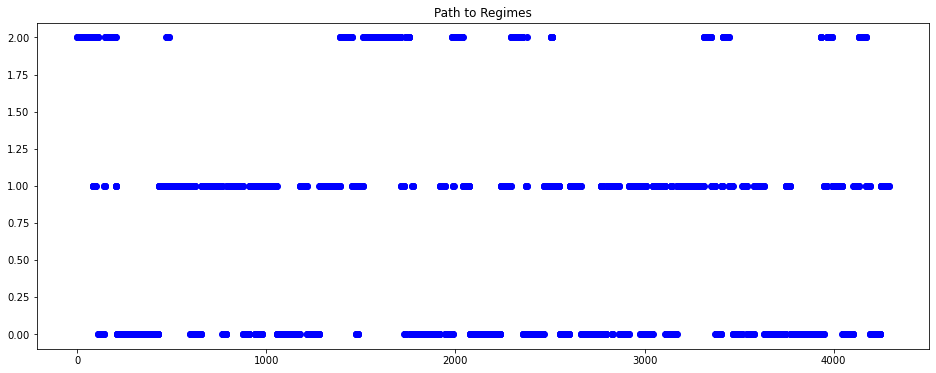

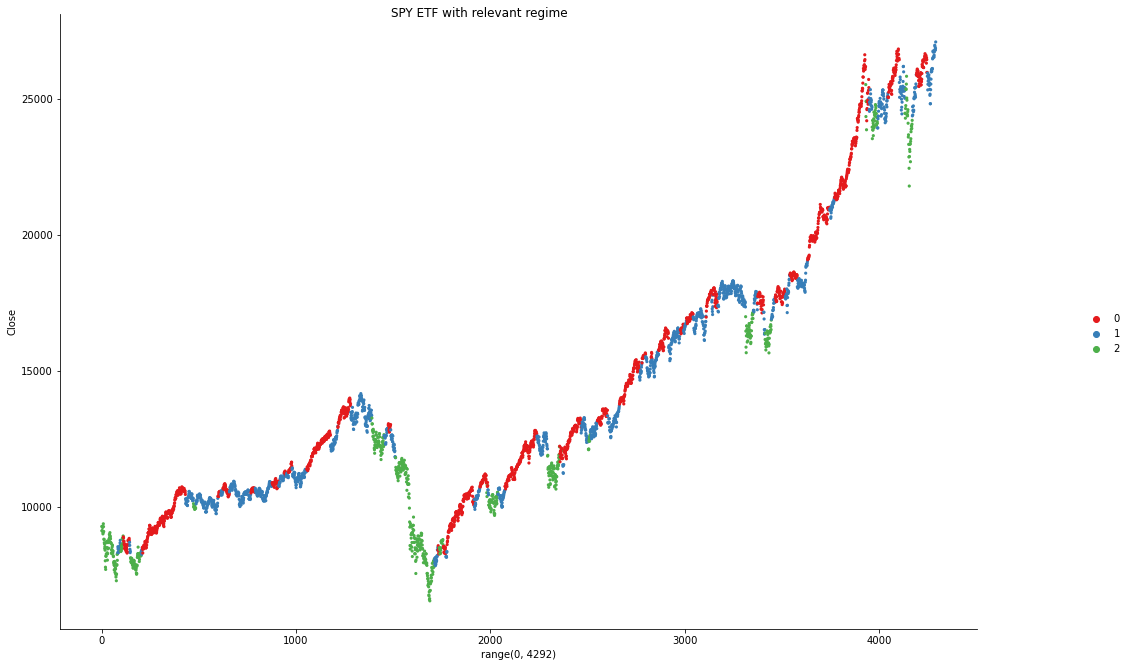



Model Score: 8608.994401697184


,prediction,Return,MA_60_days
0,0,0.080071,0.017379
1,1,0.012737,-0.000115
2,2,-0.056500,-0.024699


The Winner State is: 0 / The Loser State is: 2


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2002-06-24,9281.82,-0.060995,0.210203,-0.036247,0.184469,-0.030195,0.181407,-0.010144,0.178345,0.302903,9281.820000
1,2002-06-25,9126.82,-0.066498,0.215263,-0.054118,0.179809,-0.033600,0.183933,-0.013054,0.179674,-1.669931,9281.820000
2,2002-06-26,9120.11,-0.084332,0.200693,-0.064282,0.167709,-0.032541,0.183873,-0.014442,0.179009,-0.073520,9281.820000
3,2002-06-27,9269.92,-0.039387,0.223257,-0.052855,0.177689,-0.025252,0.186629,-0.013421,0.180220,1.642634,9281.820000
4,2002-06-28,9243.26,-0.039176,0.223249,-0.056726,0.176169,-0.026970,0.186330,-0.012991,0.180080,-0.287597,9281.820000
...,...,...,...,...,...,...,...,...,...,...,...,...
4287,2019-07-05,26922.12,0.009993,0.059001,0.023008,0.114513,0.007693,0.114985,0.015221,0.112010,-0.162723,47341.304418
4288,2019-07-08,26806.14,0.005161,0.063553,0.026630,0.109574,0.006484,0.115405,0.015126,0.112077,-0.430798,47137.358945
4289,2019-07-09,26783.49,0.003320,0.063824,0.024210,0.109631,0.006403,0.115418,0.014155,0.111813,-0.084496,47097.529966
4290,2019-07-10,26860.20,0.018546,0.051612,0.030667,0.104715,0.004449,0.113707,0.013758,0.111615,0.286408,47232.420958


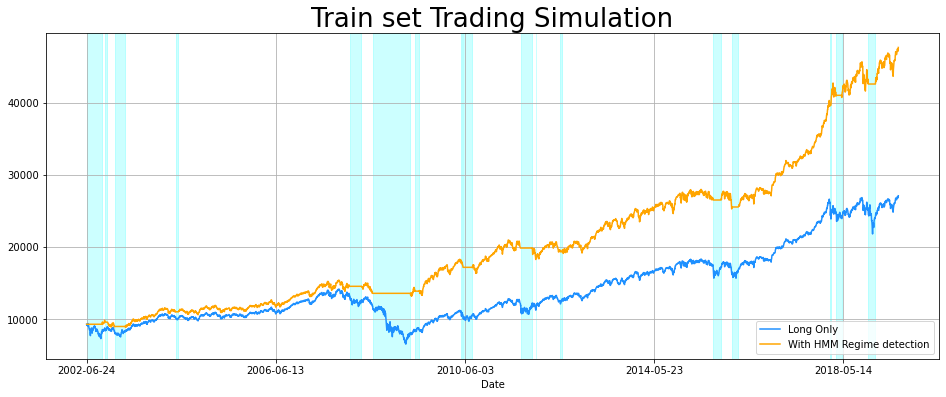

For the buy and hold trading strategy => Overall return = 191.84%  ~  Yearly return = 6.48%  ~  Z-score = 1.842
For the HMM based    trading strategy => Overall return = 413.19%  ~  Yearly return = 10.06%  ~  Z-score = 3.809


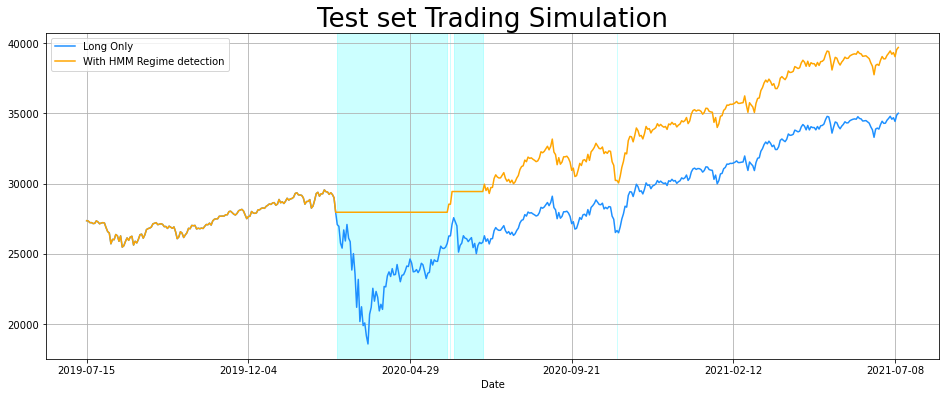

For the buy and hold trading strategy => Overall return = 27.93%  ~  Yearly return = 13.14%  ~  Z-score = 0.831
For the HMM based    trading strategy => Overall return = 45.03%  ~  Yearly return = 20.49%  ~  Z-score = 2.122


In [62]:
columns_to_remove = ['Date', 'Close']
columns_to_keep = [x for x in train.columns if x not in columns_to_remove]
columns_to_keep = ['Return', 'MA_60_days']
run_hmm_model(train, test, columns_to_keep)

As we can see its preforming very well ! - Its above market value.